## Import libraries and set up functions
Starting directory is this "..\\asset" from this notebook code

In [80]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import cv2
import matplotlib.pyplot as plt
import random
from keras.backend import clear_session
from keras.backend import get_session
import time
import math
from datetime import timedelta
# import mediapipe as mp
import csv
import pandas as pd

os.chdir("..\\asset") # change working directory

In [81]:
emotionList = ('Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt')
TRAINANNOTATIONPATH = "train_set\\annotations\\"
TRAINIMAGEPATH = "train_set\\images\\"
TRAINLANDMARKPATH = "train_set\\landmarks\\"
TESTANNOTATIONPATH = "val_set\\annotations\\"
TESTIMAGEPATH = "val_set\\images\\"
TESTLANDMARKPATH = "val_set\\landmarks\\"

def LoadAllImageNames(filePath, limit = 0, catLimit = []):
  """Load the images names and label in tuple format (label, image name)

  Args:
      filePath (str): directory of image folder
      limit (int, optional): max number of image to load. Defaults to 0.
      catLimit (list<int>, optional): array of image count limit for each class. Defaults to []*8.

  Returns:
      list<str>: shuffled list of image names
  """
  limitCounter = [0,0,0,0,0,0,0,0]
  dataSet = []
  loadCounter = 0
  for file in os.scandir(filePath):
    if (limit > 0 and loadCounter > limit):
      break
  
    name = file.name[:-4] # file name w/o file extension
    data = np.load("{}{}_exp.npy".format(TRAINANNOTATIONPATH if filePath == TRAINIMAGEPATH else TESTANNOTATIONPATH, name)) # 
    label = int(data.item(0))

    if len(catLimit) > 0 and limitCounter[label] >= catLimit[label]:
        continue
    limitCounter[label] += 1
    loadCounter += 1

    dataSet.append((label, file.name))
    if (loadCounter%10000==0):
      print("Files loaded:{}".format(loadCounter))
  
  print("Total images loaded: ", loadCounter)
  print("Images Loaded: ", limitCounter)
  random.shuffle(dataSet)
  return dataSet

# Load the pixels of a picture to numpy.ndarray format. false for test set, true for training set
# Return image in RGB format
def LoadImage(imagePath, imageName, normalize = True):
  """Load image using numpy

  Args:
      imagePath (str): image path 
      imageName (str): image name
      normalize (bool, optional): To normalize image or not. Defaults to True.

  Returns:
      numpy array: x,y,3 array
  """
  # print("{}{}{}".format(os.getcwd(), "\\"+imagePath, imageName))
  image_array = cv2.imread("{}{}{}".format(os.getcwd(), "\\"+imagePath, imageName))
  image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
  if normalize:
    image_array = image_array/255
    
  return image_array

# Extract the daata from 0 to amount from list and return it
def CropData(list, amount):
  if (len(list) < amount):
    amount = len(list)
  croppedList = list[:amount]
  del list[:amount]
  return croppedList

def LoadImages(imagePath, list):
  label = []
  data = []
  for entries in list:
    try:
      image = LoadImage(imagePath, entries[1])
      data.append(image) 
      label.append(entries[0]) 
    except: 
      print("Failed to load training image: ", entries[1])
  npLabel = np.array(label) 
  npData = np.array(data) 
  return npLabel, npData 

# Load a list of face mesh in landmark_pb2.NormalizedLandmarkList format
def LoadFaceMeshes(faceMesh, path, list, withFace = False):
  face = []
  label = []
  data = []
  for entry in list:
    # try:
    if withFace:
      face.append(LoadImage(path, entry[1], normalize = False)) # Load image
      data.append(faceMesh.process(face[-1])) # process it into face mesh and append into data
    else:
      data.append(faceMesh.process(LoadImage(path, entry[1], normalize = False))) # Load image, process it into face mesh, and append into data
    label.append(entry[0])
    # except:
      # print("Failed to load training image: ", entry[1])

  if withFace:
    return np.array(label), np.array(data), np.array(face)
  else:
    return np.array(label), np.array(data)

# Load face mesh data in numpy array of 
def LoadFaceMeshVertices(faceMesh, path, list):
  label = []
  data = []
  for entry in list:
    # load image, process it into normalizedlandmarklist format, obtain face data from the list, convert it into vertices
    image = LoadImage(path, entry[1], normalize = False)
    multiFaceLandmarks = faceMesh.process(image).multi_face_landmarks
    if (multiFaceLandmarks == None):
      print("{} multi-face landmarks is none".format(entry[1]))
      continue
    vertices = MultiLandmarkToVertices(multiFaceLandmarks[0])
    data.append(vertices)
    label.append(entry[0])
    # except:
      # print("Failed to load training image: ", entry[1])

  return np.array(label), np.array(data)
  
def MultiLandmarkToVertices(multiLandmark):
  verticesList = []
  for idx, landmark in enumerate(multiLandmark.landmark):
    verticesList.append([landmark.x, landmark.y, landmark.z])

  return verticesList


def InitializeModel():
  pretrained_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3)) # Initializing model with mobile net V3 pretrained model

  # Initializing the input and output from the model, removing last layer
  base_input = pretrained_model.layers[0].input
  base_output = pretrained_model.layers[-2].output

  # Adding 3 more layers to output side
  final_output = layers.Dense(128)(base_output) # Adding new layers, to the output side
  final_output = layers.Activation('relu')(final_output) # activating layer
  final_output = layers.Dense(64)(final_output)
  final_output = layers.Activation('relu')(final_output) # activating layer
  final_output = layers.Dense(8, activation = 'softmax')(final_output) # 8 cuz there are 8 image classifications

  new_model = keras.Model(inputs = base_input, outputs = final_output)
  # new_model.summary()
  return new_model

def ConvertToGray(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  return image

def ScaleImage(image, width):
  ratio = image.shape[1]/width
  image = cv2.resize(image, (width, int(image.shape[0]/ratio)))
  return image

def DetectFace(image):
  face_roi = np.ndarray(1)
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  faces = faceCascade.detectMultiScale(grayImage, 1.3, 5)
  for x,y,w,h in faces:
    roi_gray = grayImage[y:y+h, x:x+w]
    roi_color = image[y:y+h, x:x+w]
    cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if (len(facess) == 0):
      print("Face not detected")
    else:
      for (ex,ey,ew,eh) in facess:
        face_roi = roi_color[ey:ey+eh, ex:ex+ew]
  return face_roi

def ConvertToInput(image):
  input = ScaleImage(image, 224)
  input = np.expand_dims(input, axis = 0) ## to add fourth dimension to fit model input
  input = input/255
  return input

def GetResult(model, input):
  Predictions = model.predict(input)
  print(Predictions)
  result = np.argmax(Predictions)
  return emotionList[result]

def printDataSetLabels(dataSet):
    counterList = list(range(8))
    for label, name in dataSet:
        counterList[label] += 1
    print(counterList)
    
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    # try:
    #     del classifier # this is from global space - change this as you need
    # except:
    #     pass

    # use the same config as you used to create the session
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.9, visible_device_list="0")

class TimeHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, batch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

  def AverageTime(self):
    sum = 0
    for time in self.times:
      sum += time
    return sum/len(self.times)

def DrawFaceLandmark(label, image, landmarks):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_face_mesh = mp.solutions.face_mesh
  print(f'Face landmarks of {label}:')
  if not landmarks.multi_face_landmarks:
    print("unagle to locate face landmark for {}".format(label))
  annotated_image = image.copy()
  for face_landmarks in landmarks.multi_face_landmarks:
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_tesselation_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp_face_mesh.FACEMESH_IRISES,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_iris_connections_style())
  plt.imshow(annotated_image)
  
from typing import Mapping, Tuple
from mediapipe.python.solutions.drawing_utils import DrawingSpec
def get_default_face_mesh_connections_style(faceMeshConnections) -> Mapping[Tuple[int, int], DrawingSpec]:
  """Returns the default face mesh iris connections drawing style.

  Returns:
       A mapping from each iris connection to its default drawing spec.
  """
  face_mesh_iris_connections_style = {}
  _THICKNESS_CONTOURS = 2
  _CYAN = (192, 255, 48)
  drawSpecs = DrawingSpec(color=_CYAN, thickness=_THICKNESS_CONTOURS)
  for connection in faceMeshConnections:
    face_mesh_iris_connections_style[connection] = drawSpecs
  return face_mesh_iris_connections_style

  
def DrawCustomFaceLandmark(label, image, landmarks, landmarkParts):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_face_mesh = mp.solutions.face_mesh
  print(f'Face landmarks of {label}:')
  if not landmarks.multi_face_landmarks:
    print("unagle to locate face landmark for {}".format(label))
  annotated_image = image.copy()
  for face_landmarks in landmarks.multi_face_landmarks:
    for part in landmarkParts: # Looping through each part to draw
      # Selecting draw style
      drawStyle = get_default_face_mesh_connections_style(part)
      if (part == mp_face_mesh.FACEMESH_CONTOURS):
        drawStyle = mp_drawing_styles.get_default_face_mesh_contours_style()
      elif (part == mp_face_mesh.FACEMESH_TESSELATION):
        drawStyle = mp_drawing_styles.get_default_face_mesh_tesselation_style()
      elif (part == mp_face_mesh.FACEMESH_IRISES):
        drawStyle = mp_drawing_styles.get_default_face_mesh_iris_connections_style()

      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=part,
          landmark_drawing_spec=None,
          connection_drawing_spec=drawStyle)
  plt.imshow(annotated_image)
  
def DrawCustomFaceLandmark(label, image, landmarks, landmarkParts):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_face_mesh = mp.solutions.face_mesh
  print(f'Face landmarks of {label}:')
  if not landmarks.multi_face_landmarks:
    print("unagle to locate face landmark for {}".format(label))
  annotated_image = image.copy()
  for face_landmarks in landmarks.multi_face_landmarks:
    for part in landmarkParts: # Looping through each part to draw
      # Selecting draw style
      drawStyle = get_default_face_mesh_connections_style(part)
      if (part == mp_face_mesh.FACEMESH_CONTOURS):
        drawStyle = mp_drawing_styles.get_default_face_mesh_contours_style()
      elif (part == mp_face_mesh.FACEMESH_TESSELATION):
        drawStyle = mp_drawing_styles.get_default_face_mesh_tesselation_style()
      elif (part == mp_face_mesh.FACEMESH_IRISES):
        drawStyle = mp_drawing_styles.get_default_face_mesh_iris_connections_style()

      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=part,
          landmark_drawing_spec=None,
          connection_drawing_spec=drawStyle)
  plt.imshow(annotated_image)

# Archive

## Setup directory and import image file names

In [82]:
# Get currect directory (os.getcwd() -> C:\Users\jazzt\src)

#-----------------------Start of code---------------------------
# initialise image names and label
mainTrainSet = LoadAllImageNames(TRAINIMAGEPATH, 80, catLimit=[10]*8) #catLimit=[20]*8)
# mainTestSet = LoadAllImageNames(TESTIMAGEPATH, catLimit=[500]*8)

Total images loaded:  80
Images Loaded:  [10, 10, 10, 10, 10, 10, 10, 10]


In [4]:
mainTestSet = LoadAllImageNames(TESTIMAGEPATH, catLimit=[500]*8)

Total images loaded:  3999
Images Loaded:  [500, 500, 500, 500, 500, 500, 500, 499]


## Compiling and training model
Using pretrained mode from MobileNetV3, fine-tuning of model can be done in the first block.
In the second block, training of model can be done while tweaking the training parameters such as batch size and epoch.

In [5]:
pretrained_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),) # Initializing model with mobile net V3 pretrained model

# Initializing the input and output from the model, removing last layer
base_input = pretrained_model.layers[0].input
base_output = pretrained_model.layers[-2].output

pretrained_model.trainable = False

for layer in pretrained_model.layers:
  assert layer.trainable == False
  layer.trainable = False

#-------------------------------------------------
# Customizing layers
#-------------------------------------------------
# Adding 3 more layers to output side
final_output = layers.Dense(256)(base_output) # Adding new layers, to the output side
final_output = layers.Activation('relu')(final_output) # activating layer
final_output = layers.Dense(64)(final_output) # Adding new layers, to the output side
final_output = layers.Activation('relu')(final_output) # activating layer
final_output = layers.Dense(8, activation = 'softmax')(final_output) # 8 cuz there are 8 image classifications

model = keras.Model(inputs = base_input, outputs = final_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

time_callback = TimeHistory()
dataSet = mainTrainSet.copy()

# Initializing model fit params
batchSize = 8
imgPerIter = batchSize*16

count = 0
while(len(dataSet) != 0):
  croppedList = []
  try:
    print("loading image") # Crop and load images in
    croppedList = CropData(dataSet, imgPerIter)
    label, data = LoadImages(TRAINIMAGEPATH, croppedList)
    
    # Training model
    model.fit(data, label, epochs = 11, batch_size = batchSize, callbacks = [time_callback])
    print(time_callback.AverageTime())
  except RuntimeError as e:
    print(e)
  
  # Saving weights
  model.save_weights('freeze_bs48_512fls_128sls.h5')
  
  # Print summary of current iteration
  count = count + len(croppedList)
  timeLeft = len(dataSet)/imgPerIter * time_callback.AverageTime()
  print("trained image count: ", count)
  print("Images Left: ", len(dataSet))
  print("Estimated completion time: ", str(timedelta(seconds=timeLeft)))
  
  reset_keras()


loading image
Epoch 1/11
16/16 [==============================] - 7s 163ms/step - loss: 2.4669 - accuracy: 0.1250
Epoch 2/11
16/16 [==============================] - 3s 170ms/step - loss: 2.2631 - accuracy: 0.1172
Epoch 3/11
16/16 [==============================] - 3s 170ms/step - loss: 2.2637 - accuracy: 0.1172
Epoch 4/11
16/16 [==============================] - 3s 159ms/step - loss: 2.2193 - accuracy: 0.1797
Epoch 5/11
16/16 [==============================] - 3s 171ms/step - loss: 2.2346 - accuracy: 0.0859
Epoch 6/11
16/16 [==============================] - 3s 178ms/step - loss: 2.1399 - accuracy: 0.1719
Epoch 7/11
16/16 [==============================] - 3s 174ms/step - loss: 2.1383 - accuracy: 0.1250
Epoch 8/11
16/16 [==============================] - 3s 168ms/step - loss: 2.1133 - accuracy: 0.1328
Epoch 9/11
16/16 [==============================] - 3s 159ms/step - loss: 2.1537 - accuracy: 0.1484
Epoch 10/11
16/16 [==============================] - 3s 164ms/step - loss: 2.1451 - ac

## Testing a random image with a face
The following block of code loads a image, crop the image to just the face, and convert it into model input before inserting it into the model

In [ ]:
# Testing trained model
image = LoadImage(TESTIMAGEPATH,"3.jpg", normalize = False)
# image = cv2.resize(image, (224,224))
# image = ScaleImage(image, 224)

face = DetectFace(image)

plt.imshow(face)

preppedInput = ConvertToInput(face)
result = GetResult(model, preppedInput)


In [ ]:
# testing loading in data from tar using tensorflow
# os.chdir("C:\\Users\\j.teoh\\Desktop\\tflite-facial-expression") # change working directory
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

## Test Model
The following block of code takes in a bunch of weight names and test their accuracy and lose before printing the result out.
Insert the weight file names into "modelNames".

In [ ]:
# Testing model

modelNames = ["Limit30000Label126BatchSize48gpu.h5"]
model = InitializeModel()
mainData = LoadAllImageNames(TESTIMAGEPATH)
resultPool =[]

for modelName in modelNames:
    model.load_weights(modelName)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics=["accuracy"])

    # initialise image names and label
    testSetData = []
    testSetData.extend(mainData)
    # print(mainData)
    # test model
    lostSum = 0
    accuracySum = 0
    count = 0
    while(len(testSetData) != 0):
      # training data
      try:
        croppedList = CropData(testSetData, 100)
        print("loading image")
        label, data = LoadImages(TESTIMAGEPATH, croppedList)
        result = model.evaluate(data, label, batch_size = 1)
        lostSum += result[0]
        accuracySum += result[1]
      except:
        print("Failed to train data")

      count += 1
      reset_keras()
      # print(count)
    # print(mainData)
    print("==========FINISH TESTING===========")
    print("model name: ", modelName)
    print("average lost: ", lostSum/count)
    print("average accuracy: ", accuracySum/count)
    resultPool.append((modelName, lostSum/count, accuracySum/count))
    
print(resultPool)

## Setting up image with Keras for MobileNet

In [ ]:
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

# preparing dataset of 1000 images
dataset = trainingSetData[:1000].copy()
trainingSet = []
for label, fileName in dataset:
    # Load image and convert to 224,224,3 nested array
    tempImg = image.load_img("train_set\\images\\"+fileName, target_size = (224,224))
    tempImg = image.img_to_array(tempImg)
    
    # turn all the values in nested array into value between -1 and 1
    trainingSet.append(preprocess_input(tempImg))
    




## GPU Setting
Uncomment the first line of code to force the kernel to compute with CPU instead of GPU

In [ ]:
# tf.config.set_visible_devices([], 'GPU')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    # tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # config = tf.compat.v1.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = 0.6
    # keras.set_session(tf.Session(config=config))
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

## Mediapipe Testings
The first block of code loads in train and test images. Then convert them into 468 vertices by batches and save them to landmark folder
Prerequisite: Run the import file name code above


In [ ]:
# this code load a list of face data in facemesh vertices and save it
face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)
faceMeshDataSet = []
imagePerIter = 100

#------ For train images ------
faceMeshDataSet.extend(mainTrainSet)

while len(faceMeshDataSet) > 0:
    croppedList = CropData(faceMeshDataSet, imagePerIter)
    label, landmarkVertices = LoadFaceMeshVertices(face_mesh, TRAINIMAGEPATH, croppedList)

    count = 0
    for name, vertices in zip(croppedList, landmarkVertices):
        count += 1
        np.save("{}{}_landmark".format(TRAINLANDMARKPATH, name[1][:-4]), vertices)

    print("{} train landmark converted and saved".format(count))
faceMeshDataSet.clear()

#------ For test images ------
# faceMeshDataSet.extend(mainTestSet)

# while len(faceMeshDataSet) > 0:
#     croppedList = CropData(faceMeshDataSet, imagePerIter)
#     label, landmarkVertices = LoadFaceMeshVertices(face_mesh, TESTIMAGEPATH, croppedList)

#     count = 0
#     for name, vertices in zip(croppedList, landmarkVertices):
#         count += 1
#         np.save("{}{}_landmark".format(TESTLANDMARKPATH, name[1][:-4]), vertices)

#     print("{} test landmark converted and saved".format(count))


Face landmarks of 7:


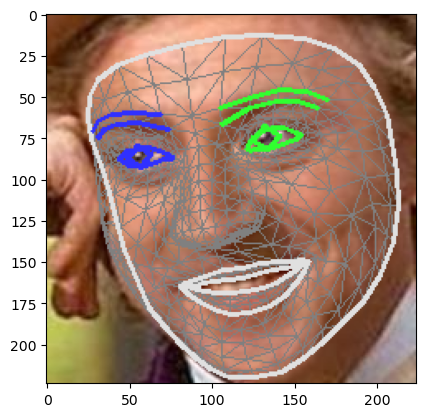

In [83]:
# Testing code for the loading of the conve
face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

faceMeshDataSet = []
faceMeshDataSet.extend(mainTrainSet)
croppedList = CropData(faceMeshDataSet, 80)

# Data containing label, face image in rgb and normalizedlandmarklist
label, landmarklists, faces = LoadFaceMeshes(face_mesh, TRAINIMAGEPATH, croppedList, True)
DrawFaceLandmark(label[0], faces[0], landmarklists[0]) # Visualise the face landmark with face image here

# Data containing label, data
# label2, landmarkVertices = LoadFaceMeshVertices(face_mesh, TRAINIMAGEPATH, croppedList)

# np.save("inputSample1", landmarkVertices[0])
# loadedData = np.load("inputSample1.npy")
# print(loadedData)
# for label, face, mesh in zip(label, faces, data):
#   DrawFaceLandmark(label,face,mesh)


In [86]:
i = 0

#emotionList = ('Neutral 0', 'Happy 1', 'Sad 2', 'Surprise 3', 'Fear 4', 'Disgust 5', 'Anger 6', 'Contempt 7')

In [55]:
mp_face_mesh = mp.solutions.face_mesh_connections
LandmarkPartsList = []
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_LIPS)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_LEFT_EYE)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_LEFT_IRIS)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_LEFT_EYEBROW)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_RIGHT_EYE)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_RIGHT_EYEBROW)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_RIGHT_IRIS)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_FACE_OVAL)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_NOSE)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_CONTOURS)
# LandmarkPartsList.append(mp_face_mesh.FACEMESH_IRISES)
LandmarkPartsList.append(mp_face_mesh.FACEMESH_TESSELATION)

Face landmarks of 4:


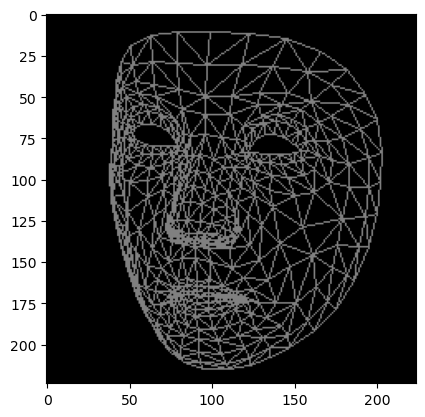

In [113]:
DrawCustomFaceLandmark(label[i], np.zeros((224,224,3), dtype=np.uint8), landmarklists[i], landmarkParts=LandmarkPartsList)
i += 1
# plt.imshow(faces[i])

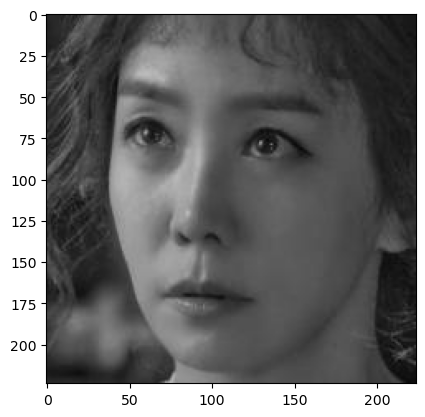

In [117]:
plt.imshow(cv2.cvtColor(cv2.cvtColor(faces[i-1], cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB))

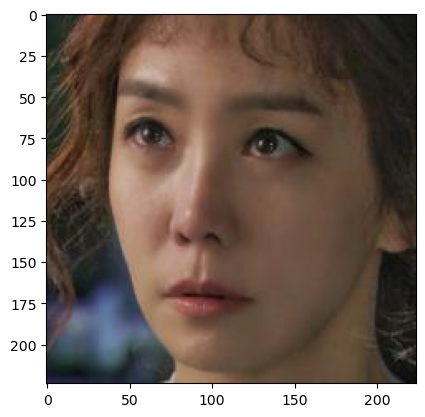

In [114]:
plt.imshow(faces[i-1])

Face landmarks of 5:


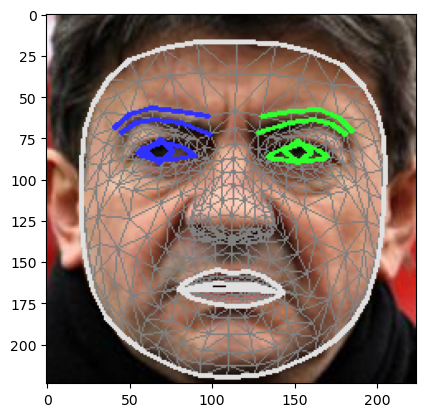

In [110]:
DrawFaceLandmark(label[i-1], faces[i-1], landmarklists[i-1])

In [11]:
croppedList[i-1]

(7, '100251.jpg')

In [ ]:
# Converting single image, input correct image file name and path name
vertices = MultiLandmarkToVertices(face_mesh.process(LoadImage(TRAINIMAGEPATH, "10017.jpg", normalize = False)).multi_face_landmarks[0])

## Tensorboard

In [3]:
# import pkg_resources
# path = "C:/Users/j.teoh/AppData/Local/miniconda3/envs/tflite-facial-expression/Lib/"
# pkg_resources.working_set.add_entry(path)
%load_ext tensorboard
%tensorboard --logdir logs/

# Current Task
Making a logistic regression neural network to predict facial expression

In [11]:
# Creating a model
# model = tf.keras.models.Sequential()x

inputs = tf.keras.Input(shape=(468,3))
base = tf.keras.layers.Dense(1024, activation='relu')(inputs)
base = tf.keras.layers.Dense(256, activation='relu')(base)
outputs = tf.keras.layers.Dense(8, activation='softmax')(base)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
# model.add(tf.keras.Input(shape=(468,3)))
# model.add(tf.keras.layers.Dense(1024))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dense(256))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(tf.keras.layers.Dense(8, activation = 'softmax')) # 8 cuz there are 8 image classifications

# model.add(tf.keras.layers.Dense(32))
# model.output_shape

In [12]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 468, 3)]          0         
                                                                 
 dense_15 (Dense)            (None, 468, 1024)         4096      
                                                                 
 dense_16 (Dense)            (None, 468, 256)          262400    
                                                                 
 dense_17 (Dense)            (None, 468, 8)            2056      
                                                                 
Total params: 268,552
Trainable params: 268,552
Non-trainable params: 0
_________________________________________________________________
